# Analiza Danych - Projekt
Marcin Jeznach 241204 \
Semestr letni 2023/24

## Zbiór danych

[Statlog (German Credit Data)](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data 'Zbiór danych - UCI')

Zbiór danych zawiera dane 1000 klientów, będących kredytobiorcami banku i klasyfikuje ich na dwie klasy (dobrych kredytobiorców i złych kredytobiorców, lub inaczej niskie i wysokie ryzyko). Celem projektu jest stworzenie modelu predykcji ryzyka kredytowego.

### Opis kolumn

Zarówno w opisie zbiory danych, jak i samym zbiorze danych, kolumny nie mają opisowych nazw - opis wymienia jedynie nazwy `Attribute 1` - `Attribute 20`. Aby zwiększyć czytelność zarówno kodu, jak i tabel/wykresów, do danych przypisane zostały własne nazwy.

Wartości kolumn kategorycznych zostały zakodowane w danych źródłowych jako `A{n}{m}`, gdzie `{n}` to numer kolumny, a `{m}` to numer kategorii. Aby ponownie zwiększyć czytelność, jako słowniki dla tych kategorii, użyte zostaną opisy wartości, przetłumaczone na język polski.

Warto również zwrócić uwagę, że zbiór danych powstał w 1994 roku, przez co wartości walutowe podawane są w Markach Niemieckich (DM).

Jeżeli nie podano inaczej, to wartości czasowe są najprawdopodobniej wyrażone w latach.

| Nazwa kolumny (oryginalna) | Nazwa kolumny (własna)    | Typ kolumny  | Opis kolumny                                                |
| -------------------------- | ------------------------- | ------------ | ----------------------------------------------------------- |
| Attribute 1                | Saldo ROR                 | kategoryczna | Bieżące saldo używanego rachunku rozliczeniowego            |
| Attribute 2                | Okres kredytowania        | numeryczna   | Czas trwania kredytu, w miesiącach                          |
| Attribute 3                | Historia kredytowa        | kategoryczna | Historia dotychczasowych kredytów i terminowosci            |
| Attribute 4                | Cel konsumpcyjny          | kategoryczna | Na co planowane jest przeznaczenie pożyczonych środków      |
| Attribute 5                | Kwota kredytu             | numeryczna   |                                                             |
| Attribute 6                | Saldo oszczędności        | kategoryczna | Suma salda rachunków oszczędnościowych i wartości obligacji |
| Attribute 7                | Bieżący staż pracy        | kategoryczna | Czas pracy w bieżącym miejscu zatrudnienia                  |
| Attribute 8                | Wskaźnik RdD              | numeryczna   | Stosunek wysokości raty miesięcznej do dochodów, w %        |
| Attribute 9                | Stan cywilny              | kategoryczna |                                                             |
| Attribute 10               | Dodatkowy dłużnik         | kategoryczna | Czy do kredytu dopisane są inne osoby / w jakim charakterze |
| Attribute 11               | Bieżący czas zamieszkania | numeryczna   | Czas zamieszkania pod obecnym adresem zamieszkania          |
| Attribute 12               | Mienie                    | kategoryczna | Inne mienie nie wymienione w saldzie oszczędności           |
| Attribute 13               | Wiek                      | numeryczna   |                                                             |
| Attribute 14               | Pozostałe zobowiązania    | kategoryczna | Czy klient posiada inne zobowiązania ratalne                |
| Attribute 15               | Typ zamieszkania          | kategoryczna | Charakter w jakim klient zamieszkuje pod obecnym adresem    |
| Attribute 16               | Liczba zobowiązań         | numeryczna   | Liczba pozostałych (niespłaconych?) zobowiązań              |
| Attribute 17               | Rodzaj zawodu             | kategoryczna |                                                             |
| Attribute 18               | Osoby na utrzymaniu       | numeryczna   | Liczba osób będących na utrzymaniu klienta                  |
| Attribute 19               | Numer telefonu            | kategoryczna | Czy klient posiada / podał(a) numer telefonu                |
| Attribute 20               | Pracownik zagraniczny     | kategoryczna | Czy klient jest pracownikiem zagranicznym                   |

Dodatkowo występuje kolumna kategoryczna z oceną ryzyka kredytowego.


#### Załadowanie danych

In [1]:
import typing as tp
import types as ts
import random
from time import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_col
import numpy as np
from scipy import stats
from sklearn import (
	preprocessing,
	model_selection,
	ensemble,
	metrics,
	inspection,
	svm,
	neural_network,
)

# Załadowanie danych
data_df = pd.read_csv(
	'./german.data',
	sep=' ', 
	names= [
		'Saldo ROR',
		'Okres kredytowania',
		'Historia kredytowa',
		'Cel konsumpcyjny',
		'Kwota kredytu',
		'Saldo oszczędności',
		'Bieżący staż pracy',
		'Wskaźnik RdD',
		'Stan cywilny',
		'Dodatkowy dłużnik',
		'Bieżący czas zamieszkania',
		'Mienie',
		'Wiek',
		'Pozostałe zobowiązania',
		'Typ zamieszkania',
		'Liczba zobowiązań',
		'Rodzaj zawodu',
		'Osoby na utrzymaniu',
		'Numer telefonu',
		'Pracownik zagraniczny',
		'Ocena ryzyka',
	],
	index_col= False,
)

# Stworzenie typu pomocniczego z listą nazw kolumn
column_t = tp.Literal[
	'Saldo ROR',
	'Okres kredytowania',
	'Historia kredytowa',
	'Cel konsumpcyjny',
	'Kwota kredytu',
	'Saldo oszczędności',
	'Bieżący staż pracy',
	'Wskaźnik RdD',
	'Stan cywilny',
	'Dodatkowy dłużnik',
	'Bieżący czas zamieszkania',
	'Mienie',
	'Wiek',
	'Pozostałe zobowiązania',
	'Typ zamieszkania',
	'Liczba zobowiązań',
	'Rodzaj zawodu',
	'Osoby na utrzymaniu',
	'Numer telefonu',
	'Pracownik zagraniczny',
	'Ocena ryzyka',
]

### Słowniki kolumn kategorycznych

Poniżej znajdują się mapowania znaczenia kolumn kategorycznych. Ewentualne objaśnienia znajdują się w komentarzu na końcu linii z daną wartością.

Jeżeli nie podano inaczej, to górna wartość zakresów jest wartością wyłączną (wartość `v` w zakresie `x` do `y` oznacza `x` <= `v` < `y`).

In [2]:
data_df['Saldo ROR'] = data_df['Saldo ROR'].map({
	'A11': 'Poniżej 0 DM',
	'A12': '0 DM do 200 DM',
	'A13': 'Ponad 200 DM',
	'A14': 'Brak ROR',
})

data_df['Historia kredytowa'] = data_df['Historia kredytowa'].map({
	'A30': 'Nigdy nie brano lub Wszystkie spłacono w terminach',
	'A31': 'Wszystkie kredyty wewnętrzne spłacono w terminie', # Przez kredyty wewnętrzne danego banku, rozumie się takie których dany bank jest kredytodawcą
	'A32': 'Istniejące kredyty dotychczasowo spłacono w terminie',
	'A33': 'W przeszłości występowały opóźnienia w spłacie',
	'A34': 'Krytyczny rachunek lub istniejące kredyty zewnętrzne',
})

data_df['Cel konsumpcyjny'] = data_df['Cel konsumpcyjny'].map({
	'A40': 'Samochód nowy',
	'A41': 'Samochód używany',
	'A42': 'Meble i wyposażenie',
	'A43': 'RTV',
	'A44': 'AGD',
	'A45': 'Naprawy',
	'A46': 'Edukacja',
	'A47': 'Wakacje',
	'A48': 'Szkolenia', # Wartość oryginalna 'retraining', może również oznaczać przekwalifikowanie
	'A49': 'Wydatki biznesowe',
	'A410': 'Inne',
})

data_df['Saldo oszczędności'] = data_df['Saldo oszczędności'].map({
	'A61': 'Poniżej 100 DM',
	'A62': '100 DM do 500 DM',
	'A63': '500 DM do 1000 DM',
	'A64': 'Powyżej 1000 DM',
	'A65': 'Brak lub nieznana wartość',
})

data_df['Bieżący staż pracy'] = data_df['Bieżący staż pracy'].map({
	'A71': 'Bezrobotny/a',
	'A72': 'Do 1 roku',
	'A73': '1 do 4 lat',
	'A74': '4 do 7 lat',
	'A75': 'Powyżej 7 lat',
})

data_df['Stan cywilny'] = data_df['Stan cywilny'].map({
	'A91': 'Rozwodnik lub w separacji',
	'A92': 'Rozwódka, w separacji lub zamężna',
	'A94': 'Kawaler',
	'A93': 'Żonaty lub wdowiec',
	'A95': 'Panna',
})

data_df['Dodatkowy dłużnik'] = data_df['Dodatkowy dłużnik'].map({
	'A101': 'Brak',
	'A102': 'Współkredytobiorca',
	'A103': 'Poręczyciel',
})

data_df['Mienie'] = data_df['Mienie'].map({
	'A121': 'Nieruchomości',
	'A122': 'Oszczędności w Towarzystwie Budowlanym lub Ubezpieczenie na życie',
	'A123': 'Samochód lub inne (nie dotyczy oszczędności)',
	'A124': 'Nieznane lub brak majątku nieruchomego',
})

data_df['Pozostałe zobowiązania'] = data_df['Pozostałe zobowiązania'].map({
	'A141': 'Kredyty bankowe',
	'A142': 'Zakupy na raty',
	'A143': 'Brak',
})

data_df['Typ zamieszkania'] = data_df['Typ zamieszkania'].map({
	'A151': 'Wynajem',
	'A152': 'Nieruchomość na własność',
	'A153': 'Mieszkanie socjalne', # Wartość oryginalna to 'for free', ciężko znaleźć inne sensowne tłumaczenie
})

data_df['Rodzaj zawodu'] = data_df['Rodzaj zawodu'].map({
	'A171': 'Bezrobotny lub niewykwalifikowany/a - brak obywatelstwa',
	'A172': 'Niewykwalifikowany/a - obywatel(ka)',
	'A173': 'Wykwalifikowany/a lub Urzędnik/czka',
	'A174': 'Kadra menedżerska, Samozatrudnienie, Wysokie kwalifikacje lub Funkcjonariusz(ka)',
})

data_df['Numer telefonu'] = data_df['Numer telefonu'].map({
	'A191': 'Brak numeru telefonu',
	'A192': 'Numer telefonu zarejestrowany na danego klienta',
})

data_df['Pracownik zagraniczny'] = data_df['Pracownik zagraniczny'].map({
	'A201': 'Tak',
	'A202': 'Nie',
})

data_df['Ocena ryzyka'] = data_df['Ocena ryzyka'].map({
	1: 'Niskie ryzyko / dobry klient',
	2: 'Wysokie ryzyko / zły klient',
})

display(data_df.head())

,Saldo ROR,Okres kredytowania,Historia kredytowa,Cel konsumpcyjny,Kwota kredytu,Saldo oszczędności,Bieżący staż pracy,Wskaźnik RdD,Stan cywilny,Dodatkowy dłużnik,...,Mienie,Wiek,Pozostałe zobowiązania,Typ zamieszkania,Liczba zobowiązań,Rodzaj zawodu,Osoby na utrzymaniu,Numer telefonu,Pracownik zagraniczny,Ocena ryzyka
0,Poniżej 0 DM,6,Krytyczny rachunek lub istniejące kredyty zewn...,RTV,1169,Brak lub nieznana wartość,Powyżej 7 lat,4,Żonaty lub wdowiec,Brak,...,Nieruchomości,67,Brak,Nieruchomość na własność,2,Wykwalifikowany/a lub Urzędnik/czka,1,Numer telefonu zarejestrowany na danego klienta,Tak,Niskie ryzyko / dobry klient
1,0 DM do 200 DM,48,Istniejące kredyty dotychczasowo spłacono w te...,RTV,5951,Poniżej 100 DM,1 do 4 lat,2,"Rozwódka, w separacji lub zamężna",Brak,...,Nieruchomości,22,Brak,Nieruchomość na własność,1,Wykwalifikowany/a lub Urzędnik/czka,1,Brak numeru telefonu,Tak,Wysokie ryzyko / zły klient
2,Brak ROR,12,Krytyczny rachunek lub istniejące kredyty zewn...,Edukacja,2096,Poniżej 100 DM,4 do 7 lat,2,Żonaty lub wdowiec,Brak,...,Nieruchomości,49,Brak,Nieruchomość na własność,1,Niewykwalifikowany/a - obywatel(ka),2,Brak numeru telefonu,Tak,Niskie ryzyko / dobry klient
3,Poniżej 0 DM,42,Istniejące kredyty dotychczasowo spłacono w te...,Meble i wyposażenie,7882,Poniżej 100 DM,4 do 7 lat,2,Żonaty lub wdowiec,Poręczyciel,...,Oszczędności w Towarzystwie Budowlanym lub Ube...,45,Brak,Mieszkanie socjalne,1,Wykwalifikowany/a lub Urzędnik/czka,2,Brak numeru telefonu,Tak,Niskie ryzyko / dobry klient
4,Poniżej 0 DM,24,W przeszłości występowały opóźnienia w spłacie,Samochód nowy,4870,Poniżej 100 DM,1 do 4 lat,3,Żonaty lub wdowiec,Brak,...,Nieznane lub brak majątku nieruchomego,53,Brak,Mieszkanie socjalne,2,Wykwalifikowany/a lub Urzędnik/czka,2,Brak numeru telefonu,Tak,Wysokie ryzyko / zły klient


Dane nie posiadają wartości brakujących, ani identyfikatorów - dalsze przekształcenia nie są konieczne.

## Analiza danych

### Statystyki wartości numerycznych

In [3]:
display(data_df.select_dtypes('int')
	.describe()
)

,Okres kredytowania,Kwota kredytu,Wskaźnik RdD,Bieżący czas zamieszkania,Wiek,Liczba zobowiązań,Osoby na utrzymaniu
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


#### Klienci z niskim ryzykiem

In [4]:
display(data_df[data_df['Ocena ryzyka'] == 'Niskie ryzyko / dobry klient']
	.select_dtypes('int')
	.describe()
)

,Okres kredytowania,Kwota kredytu,Wskaźnik RdD,Bieżący czas zamieszkania,Wiek,Liczba zobowiązań,Osoby na utrzymaniu
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,19.207143,2985.457143,2.920000,2.842857,36.224286,1.424286,1.155714
std,11.079564,2401.472278,1.128078,1.108373,11.381145,0.584721,0.362844
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1375.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2244.000000,3.000000,3.000000,34.000000,1.000000,1.000000
75%,24.000000,3634.750000,4.000000,4.000000,42.250000,2.000000,1.000000
max,60.000000,15857.000000,4.000000,4.000000,75.000000,4.000000,2.000000


#### Klienci z wysokim ryzykiem

In [5]:
display(data_df[data_df['Ocena ryzyka'] == 'Wysokie ryzyko / zły klient']
	.select_dtypes('int')
	.describe()
)

,Okres kredytowania,Kwota kredytu,Wskaźnik RdD,Bieżący czas zamieszkania,Wiek,Liczba zobowiązań,Osoby na utrzymaniu
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,24.860000,3938.126667,3.096667,2.850000,33.963333,1.366667,1.153333
std,13.282639,3535.818955,1.088395,1.094605,11.222379,0.559702,0.360911
min,6.000000,433.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1352.500000,2.000000,2.000000,25.000000,1.000000,1.000000
50%,24.000000,2574.500000,4.000000,3.000000,31.000000,1.000000,1.000000
75%,36.000000,5141.500000,4.000000,4.000000,40.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,74.000000,4.000000,2.000000


Rozkład ocen ryzyka klientów wynosi 700-300 (niskie-wysokie), co może potencjalnie wymagać balansowania.

Na pierwszy rzut oka, z wyjątkiem okresu kredytowania oraz kwoty kredytu, reszta kolumn numerycznych ma zbliżone wartości średnie.

### Tabele krzyżowe wartości kategorycznych

In [6]:
def get_crosstab(col: column_t):
	"""
	Zwraca tabelę krzyżową dla podanej kolumny ``col``, względem oceny ryzyka.
	"""
	return pd.crosstab(
		data_df['Ocena ryzyka'],
		data_df[col],
		normalize='index'
	).style.background_gradient(
		axis= None,
		cmap= 'pink',
	)

display(get_crosstab('Saldo ROR'))
display(get_crosstab('Historia kredytowa'))
display(get_crosstab('Cel konsumpcyjny'))
display(get_crosstab('Saldo oszczędności'))
display(get_crosstab('Bieżący staż pracy'))
display(get_crosstab('Stan cywilny'))
display(get_crosstab('Dodatkowy dłużnik'))
display(get_crosstab('Mienie'))
display(get_crosstab('Pozostałe zobowiązania'))
display(get_crosstab('Typ zamieszkania'))
display(get_crosstab('Rodzaj zawodu'))
display(get_crosstab('Numer telefonu'))
display(get_crosstab('Pracownik zagraniczny'))

Saldo ROR,0 DM do 200 DM,Brak ROR,Ponad 200 DM,Poniżej 0 DM
Ocena ryzyka,,,,
Niskie ryzyko / dobry klient,0.234286,0.497143,0.070000,0.198571
Wysokie ryzyko / zły klient,0.350000,0.153333,0.046667,0.450000


Historia kredytowa,Istniejące kredyty dotychczasowo spłacono w terminie,Krytyczny rachunek lub istniejące kredyty zewnętrzne,Nigdy nie brano lub Wszystkie spłacono w terminach,W przeszłości występowały opóźnienia w spłacie,Wszystkie kredyty wewnętrzne spłacono w terminie
Ocena ryzyka,,,,,
Niskie ryzyko / dobry klient,0.515714,0.347143,0.021429,0.085714,0.030000
Wysokie ryzyko / zły klient,0.563333,0.166667,0.083333,0.093333,0.093333


Cel konsumpcyjny,AGD,Edukacja,Inne,Meble i wyposażenie,Naprawy,RTV,Samochód nowy,Samochód używany,Szkolenia,Wydatki biznesowe
Ocena ryzyka,,,,,,,,,,
Niskie ryzyko / dobry klient,0.011429,0.040000,0.010000,0.175714,0.020000,0.311429,0.207143,0.122857,0.011429,0.090000
Wysokie ryzyko / zły klient,0.013333,0.073333,0.016667,0.193333,0.026667,0.206667,0.296667,0.056667,0.003333,0.113333


Saldo oszczędności,100 DM do 500 DM,500 DM do 1000 DM,Brak lub nieznana wartość,Poniżej 100 DM,Powyżej 1000 DM
Ocena ryzyka,,,,,
Niskie ryzyko / dobry klient,0.098571,0.074286,0.215714,0.551429,0.060000
Wysokie ryzyko / zły klient,0.113333,0.036667,0.106667,0.723333,0.020000


Bieżący staż pracy,1 do 4 lat,4 do 7 lat,Bezrobotny/a,Do 1 roku,Powyżej 7 lat
Ocena ryzyka,,,,,
Niskie ryzyko / dobry klient,0.335714,0.192857,0.055714,0.145714,0.270000
Wysokie ryzyko / zły klient,0.346667,0.130000,0.076667,0.233333,0.213333


Stan cywilny,Kawaler,Rozwodnik lub w separacji,"Rozwódka, w separacji lub zamężna",Żonaty lub wdowiec
Ocena ryzyka,,,,
Niskie ryzyko / dobry klient,0.095714,0.042857,0.287143,0.574286
Wysokie ryzyko / zły klient,0.083333,0.066667,0.363333,0.486667


Dodatkowy dłużnik,Brak,Poręczyciel,Współkredytobiorca
Ocena ryzyka,,,
Niskie ryzyko / dobry klient,0.907143,0.060000,0.032857
Wysokie ryzyko / zły klient,0.906667,0.033333,0.060000


Mienie,Nieruchomości,Nieznane lub brak majątku nieruchomego,Oszczędności w Towarzystwie Budowlanym lub Ubezpieczenie na życie,Samochód lub inne (nie dotyczy oszczędności)
Ocena ryzyka,,,,
Niskie ryzyko / dobry klient,0.317143,0.124286,0.230000,0.328571
Wysokie ryzyko / zły klient,0.200000,0.223333,0.236667,0.340000


Pozostałe zobowiązania,Brak,Kredyty bankowe,Zakupy na raty
Ocena ryzyka,,,
Niskie ryzyko / dobry klient,0.842857,0.117143,0.040000
Wysokie ryzyko / zły klient,0.746667,0.190000,0.063333


Typ zamieszkania,Mieszkanie socjalne,Nieruchomość na własność,Wynajem
Ocena ryzyka,,,
Niskie ryzyko / dobry klient,0.091429,0.752857,0.155714
Wysokie ryzyko / zły klient,0.146667,0.620000,0.233333


Rodzaj zawodu,Bezrobotny lub niewykwalifikowany/a - brak obywatelstwa,"Kadra menedżerska, Samozatrudnienie, Wysokie kwalifikacje lub Funkcjonariusz(ka)",Niewykwalifikowany/a - obywatel(ka),Wykwalifikowany/a lub Urzędnik/czka
Ocena ryzyka,,,,
Niskie ryzyko / dobry klient,0.021429,0.138571,0.205714,0.634286
Wysokie ryzyko / zły klient,0.023333,0.170000,0.186667,0.620000


Numer telefonu,Brak numeru telefonu,Numer telefonu zarejestrowany na danego klienta
Ocena ryzyka,,
Niskie ryzyko / dobry klient,0.584286,0.415714
Wysokie ryzyko / zły klient,0.623333,0.376667


Pracownik zagraniczny,Nie,Tak
Ocena ryzyka,,
Niskie ryzyko / dobry klient,0.047143,0.952857
Wysokie ryzyko / zły klient,0.013333,0.986667


*Powyższe tabele krzyżowe zostały znormalizowane na poziomie wierszy, dając liczności wyrażone w procentach.*

Tabele krzyżowe dla stanu cywilnego, występowania dodatkowego dłużnika, oraz czy osoba jest pracownikiem zagranicznym, wskazują niezbyt różnice w licznościach danych grup - może to oznaczać małe powiązanie tych zmiennych.

W przypadku faktu posiadania numeru telefonu, różnice liczności są już małe, a w przypadku rodzaju wykonywanego zawodu - w większości grup znikome; można wstępnie założyć brak powiązania zmiennych do oceny ryzyka.

## Przygotowanie danych

### Balansowanie danych

Aby móc dokonać poprawnego wyboru cech

Aby zbalansować zbiory danych wg kategorii, dokonamy duplikacji rekordów (niskie ryzyko ⨉ 2, wysokie ryzyko ⨉ 5), co sprawi że stosunek klasy niskiego ryzyka do wysokiego znacznie się wyrówna z `1 : 0.429` do `1 : 1.07`.

In [7]:
data_df_good = data_df[data_df['Ocena ryzyka'] == 'Niskie ryzyko / dobry klient']
data_df_bad = data_df[data_df['Ocena ryzyka'] == 'Wysokie ryzyko / zły klient']

data_df_good_os = pd.concat([data_df_good] * 2, ignore_index= True)
data_df_bad_os = pd.concat([data_df_bad] * 5, ignore_index= True)

data_df = pd.concat([data_df_good_os, data_df_bad_os], ignore_index= True)

Jak wspomniano wcześniej, dalsze przekształcenia nie są konieczne - dane nie posiadają pustych wartości, natomiast ich mieszanie zostanie wykonane przez algorytmy do podziału na zestawy treningowe/testowe.

### Analiza wyboru cech

Test Chi-kwadrat

In [8]:
chi_table = pd.DataFrame(columns= ['Kolumna', 'Typ', 'Chi^2', 'P-val[%]'])

col: column_t
for col in data_df.columns:
	if col == 'Ocena ryzyka': continue
	contingency = pd.crosstab(data_df[col], data_df['Ocena ryzyka'])
	chi_2, p, _, _ = stats.chi2_contingency(contingency)
	typ = 'num' if data_df[col].dtype == 'int64' else 'kat'
	chi_table.loc[
		len(chi_table),
		['Kolumna', 'Typ', 'Chi^2', 'P-val[%]']
	] = (col, typ, chi_2, p)

chi_table['P-val[%]'] *= 100

display(
	chi_table.style.background_gradient(
		axis= None,
		cmap= 'summer',
		subset= 'P-val[%]',
	).format({
		'P-val[%]': '{:.2f}'
	})
)

,Kolumna,Typ,Chi^2,P-val[%]
0,Saldo ROR,kat,447.138806,0.00
1,Okres kredytowania,num,274.123290,0.00
2,Historia kredytowa,kat,194.645335,0.00
3,Cel konsumpcyjny,kat,119.258774,0.00
4,Kwota kredytu,num,2733.452759,0.00
5,Saldo oszczędności,kat,137.120639,0.00
6,Bieżący staż pracy,kat,61.636323,0.00
7,Wskaźnik RdD,num,19.016607,0.03
8,Stan cywilny,kat,32.065799,0.00
9,Dodatkowy dłużnik,kat,22.520510,0.00


Zgodnie z testem widać, że z wyjątkiem `Bieżący czas zamieszkania`, `Osoby na utrzymaniu`,
oraz w mniejszym stopniu `Rodzaj zawodu`, większość zmiennych jest powiązana z finalnym wynikiem ryzyka.

Do treningu modelu wybierzemy zmienne posiadające wartość `'P-val'` < 4, a jeżeli wyniki treningu będą niezadowalające, ograniczymy się do zmiennych z wartością  `'P-val'` < 0.1.

### Wybór zmiennych do tworzenia modeli

In [9]:
model_cols_df = chi_table[chi_table['P-val[%]'] < 4.0]
model_cols_df = model_cols_df[['Kolumna', 'Typ']]
model_cols_df = pd.concat([
	model_cols_df,
	pd.DataFrame({'Kolumna': 'Ocena ryzyka', 'Typ': 'kat'}, index= [0]),
], ignore_index=True)
display(model_cols_df)

,Kolumna,Typ
0,Saldo ROR,kat
1,Okres kredytowania,num
2,Historia kredytowa,kat
3,Cel konsumpcyjny,kat
4,Kwota kredytu,num
5,Saldo oszczędności,kat
6,Bieżący staż pracy,kat
7,Wskaźnik RdD,num
8,Stan cywilny,kat
9,Dodatkowy dłużnik,kat


## Trening modeli

### Przygotowanie strategii kodowania zmiennych kategorycznych

Pomimo że mamy dostarczone dwie wersje danych - z kodowanymi wartościami kategorycznymi (`A{n}{m}`), oraz drugą z numerycznymi wartościami kategorii, to do tworzenia modeli zastosujemy `LabelEncoder` z pakietu `sklearn.preprocessing`; dodatkowo stworzymy klasę pomocniczą która pozwoli nam później na łatwe dekodowanie danych.

In [10]:
selected_data = data_df[model_cols_df['Kolumna']].copy()

class LabelDecoder(object):
	"""
	Klasa do dekodowania zarejestrowanych kolumn w ramkach danych.
	"""
	def __init__(self):
		self.encoders: dict[str, preprocessing.LabelEncoder] = {}
	
	@tp.overload
	def decode_columns(self, data: pd.Series, col_name: str | None = None) -> pd.Series:
		pass
	
	@tp.overload
	def decode_columns(self, data: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
		pass

	def decode_columns(self,
		data: pd.DataFrame | pd.Series,
		col: list[str] | str | None = None
	):
		"""
		Odkodowuje wszystkie kolumny wymienione w ``cols`` w ramce ``df``.
		Zwraca nową ramkę.
		"""
		assert isinstance(data, (pd.DataFrame, pd.Series))
		if isinstance(data, pd.DataFrame):
			result = data.copy()
			assert isinstance(col, list)
			for name in col:
				if name not in self.encoders:
					raise ValueError(f'No encoder found for column: {name}')
				result[name] = self.encoders[name].inverse_transform(result[name])
			return result
		else:
			assert isinstance(col, (str, ts.NoneType))
			name = col if col is not None else data.name
			return pd.Series(self.encoders[name].inverse_transform(data), name= name)


ld = LabelDecoder()
for _, row in model_cols_df.iterrows():
	col: column_t = row['Kolumna']
	if row['Typ'] == 'kat':
		le = preprocessing.LabelEncoder()
		le.fit(selected_data[col])
		selected_data[col] = le.transform(selected_data[col])
		ld.encoders[col] = le

### Podział danych 

Rozdzielamy wczytaną tabelę na tabelę zmiennych wejściowych oraz serię wartości wyjściowych oceny ryzyka.

Dodatkowo rozdzielamy zestaw danych na dane treningowe oraz dane testowe, starając się zachować równomierne proporcje ocen ryzyka w obydwu zbiorach.

W poniżej zastosowanym algorytmie który wykorzystuje element losowości, jak i w kolejnych algorytmach które dają losowe wyniki w kolejnych wywołaniach, przekazujemy parametr `random_state=`. Wartość tego parametru będzie pochodzić z listy metaforycznych "*rzutów kostką*" - każdy model będziemy trenować 10 razy aby sprawdzić jak zachowuje się przy różnych zestawach danych.

In [11]:
# Typ pomocniczy dla danych modelowych
model_data_t = tp.TypedDict('model_data_t', {
	'in': pd.DataFrame,
	'out': pd.Series,
})

# Podział danych modelowych na wejściowe i wyjściowe; przygotowanie "rzutów"
model_data: model_data_t = {
	'in': selected_data.drop('Ocena ryzyka', axis=1),
	'out': selected_data['Ocena ryzyka'],
}
random.seed(42)
dice_throws = [random.randint(0, 42_000_000) for _ in range(10)]

# Podział danych na treningowe i testowe
train_data = [model_data_t() for _ in range(10)]
test_data = [model_data_t() for _ in range(10)]

for i, throw in enumerate(dice_throws):
	model_split = model_selection.StratifiedShuffleSplit(
		n_splits= 1,
		test_size= 0.3,
		random_state= throw,
	)
	train_idx, test_idx =  next(model_split.split(
		model_data['in'],
		model_data['out'],
	))
	train_data[i]['in'] = pd.DataFrame(model_data['in'].iloc[train_idx])
	test_data[i]['in'] = pd.DataFrame(model_data['in'].iloc[test_idx])
	train_data[i]['out'] = pd.DataFrame(model_data['out'].iloc[train_idx])['Ocena ryzyka']
	test_data[i]['out'] = pd.DataFrame(model_data['out'].iloc[test_idx])['Ocena ryzyka']


Dane treningowe (w jednym zestawie):

In [12]:
display(
	ld.decode_columns(train_data[0]['out'])
		.to_frame()
		.groupby('Ocena ryzyka')
		.size()
		.reset_index(name= 'Liczba wpisów')
)

,Ocena ryzyka,Liczba wpisów
0,Niskie ryzyko / dobry klient,980
1,Wysokie ryzyko / zły klient,1050


Dane testowe (jw.):

In [13]:
display(
	ld.decode_columns(test_data[0]['out'])
		.to_frame()
		.groupby('Ocena ryzyka')
		.size()
		.reset_index(name= 'Liczba wpisów')
)

,Ocena ryzyka,Liczba wpisów
0,Niskie ryzyko / dobry klient,420
1,Wysokie ryzyko / zły klient,450


### Wybór modeli

Użyjemy dużego podzakresu klasyfikatorów dostępnych w pakiecie `sklearn`.

#### Klasyfikatory oparte o drzewa decyzyjne:

- `BaggingClassifier`
  - **Jak działa**: Trenuje wiele modeli na losowych podzbiorach danych i przeprowadza głosowanie (dla klasyfikacji).
  - **Zalety**: Zmniejsza wariancję i ryzyko nadmiernego dopasowania.
  - **Wady**: Wymaga więcej zasobów obliczeniowych przy dużych zbiorach danych.

- `AdaBoostClassifier`
  - **Jak działa**: Buduje modele sekwencyjnie, kładąc większy nacisk na trudne przykłady w kolejnych iteracjach.
  - **Zalety**: Skuteczny na niewielkich zestawach danych, dobrze radzi sobie z prostymi modelami bazowymi.
  - **Wady**: Wrażliwy na szum w danych i wartości odstające.

- `ExtraTreesClassifier`
  - **Jak działa**: Tworzy wiele losowych drzew decyzyjnych, które głosują nad wynikiem.
  - **Zalety**: Bardzo szybki i mniej podatny na nadmierne dopasowanie w porównaniu do zwykłych lasów losowych.
  - **Wady**: Może mieć niższą dokładność na bardzo małych zestawach danych.

- `RandomForestClassifier`
  - **Jak działa**: Buduje zbiór drzew decyzyjnych na losowych podpróbach danych i uśrednia ich wyniki.
  - **Zalety**: Wszechstronny, dobrze radzi sobie z danymi o różnym charakterze.
  - **Wady**: Wolniejszy przy dużej liczbie drzew.

- `GradientBoostingClassifier`
  - **Jak działa**: Optymalizuje sekwencyjne uczenie modeli, minimalizując błędy poprzednich iteracji.
  - **Zalety**: Skuteczny w przypadku małych i średnich zbiorów danych.
  - **Wady**: Powolny proces treningu i podatność na nadmierne dopasowanie.

- `HistGradientBoostingClassifier`
  - **Jak działa**: Wykorzystuje histogramy do szybkiego podziału danych i przyspieszenia Gradient Boostingu.
  - **Zalety**: Bardzo szybki i dobrze skalowalny przy dużych zbiorach danych.
  - **Wady**: Może być trudniejszy w dostrojeniu dla mniej złożonych zbiorów danych.

#### Klasyfikatory nieliniowe:
- `SVC` (Support Vector Classifier, kernel nieliniowy)
  - **Jak działa**: Klasyfikator oparty na maszynach wektorów nośnych, który wykorzystuje jądra (np. RBF) do modelowania nieliniowych zależności.
  - **Zalety**: Doskonały w przypadku skomplikowanych granic decyzyjnych.
  - **Wady**: Wolny trening na dużych zbiorach danych.
- `MLPClassifier` (Multi-Layer Perceptron)
  - **Jak działa**: Sieć neuronowa z funkcją aktywacji nieliniowej, która może uczyć się skomplikowanych zależności.
  - **Zalety**: Skuteczny w przypadku złożonych danych i nieliniowych granic decyzyjnych.
  - **Wady**: Wymaga dużej ilości zasobów obliczeniowych i dostrojenia hiperparametrów.


### Trening

Jak wcześniej wspomniano, każdy z modeli będzie trenowany 10 razy, recyklingując wartości z listy "*rzutów kostką*" jako wartości parametru `random_state`, który występuje w każdym z klasyfikatorów.

Wyniki każdego treningu, oraz pomiary czasów trenowania zostaną zapisane w strukturze danych, tak aby móc później przeprowadzić analizy agregacyjne. 

In [14]:
# Definicje typów - dla niezainteresowanych nie trzeba tego czytać
sklearn_classifiers_t = tp.Union[
	ensemble.BaggingClassifier,
	ensemble.AdaBoostClassifier,
	ensemble.ExtraTreesClassifier,
	ensemble.RandomForestClassifier,
	ensemble.GradientBoostingClassifier,
	ensemble.HistGradientBoostingClassifier,
	svm.SVC,
	neural_network.MLPClassifier,
]

sklearn_classifier_names_t = tp.Literal[
    'BaggingClassifier',
  		'AdaBoostClassifier',
  		'ExtraTreesClassifier',
  		'RandomForestClassifier',
  		'GradientBoostingClassifier',
  		'HistGradientBoostingClassifier',
  		'SVC',
  		'MLPClassifier'
]

CV_t = tp.TypeVar('CV_t')
classifier_dict_t = dict[sklearn_classifier_names_t, CV_t]

model_results_t = tp.TypedDict('model_results_t', {
	'predictions': np.array,
	'impact': tp.Union[np.array, None],
	'train_dur': int,
})

In [15]:
# Lista klasyfikatorów do trenowania - parametr `random_state` będzie zasilany dynamicznie
classifiers: classifier_dict_t[sklearn_classifiers_t] = {
	'BaggingClassifier': ensemble.BaggingClassifier(random_state= None),
	'AdaBoostClassifier': ensemble.AdaBoostClassifier(random_state= None, algorithm='SAMME'),
	'ExtraTreesClassifier': ensemble.ExtraTreesClassifier(random_state= None),
	'RandomForestClassifier': ensemble.RandomForestClassifier(random_state= None),
	'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(random_state= None),
	'HistGradientBoostingClassifier': ensemble.HistGradientBoostingClassifier(random_state= None),
	'SVC': svm.SVC(probability= True, random_state= None),
	'MLPClassifier': neural_network.MLPClassifier(random_state= None),
}

# Struktura z wynikami treningów klasyfikatorów
model_results: classifier_dict_t[list[model_results_t]] = { c: [] for c in classifiers }

# Treningi poszczególnych klasyfikatorów
for c_name, classifier in classifiers.items():
	for throw, train_datum, test_datum in zip(dice_throws, train_data, test_data):
		# Dynamiczne zasilenie `random_state`
		classifier.set_params(random_state= throw)

		# Trening z pomiarem czasu
		start_time = time()
		classifier.fit(train_datum['in'], train_datum['out'])
		duration = time() - start_time

		if hasattr(classifier, 'feature_importances_'):
			feature_importances = classifier.feature_importances_.copy()
		else:
			feature_importances = None

		# Zapis wyników
		model_results[c_name].append({
			'predictions': classifier.predict(test_datum['in']),
			'impact': feature_importances,
			'train_dur': duration,
		})

### Ewaluacja modeli

Ze względu na długość kodu, wizualizacje zostaną wyświetlone po zdefiniowaniu wszystkich raportów.

##### Raport klasyfikacji

Aby uśrednić wyniki klasyfikacji, zestawy testowe oraz zestawy przewidywań zostaną złączone w odpowiednie zestawy - wyniki będą policzone dla 10x większego zestawu wartości niż przy pojedynczym treningu.

In [16]:
# Unie zestawów danych
all_expected = pd.concat([test_datum['out'] for test_datum in test_data])
all_predicted: classifier_dict_t[np.ndarray] = {
	c_name: np.concatenate([ result['predictions'] for result in model_results[c_name] ])
	for c_name
	in model_results
}

# Stworzenie pełnego raportu
reports: list[pd.DataFrame] = []
for c_name, predictions in all_predicted.items():
	name = all_expected.name
	expected = ld.decode_columns(all_expected)
	predicted = ld.decode_columns(pd.Series(predictions, name= name))

	report = pd.DataFrame(metrics.classification_report(
		expected,
		predicted,
		output_dict= True,
	)).transpose()

	report.index = pd.MultiIndex.from_tuples(
		[ (c_name, idx) for idx in report.index ],
		names= ["Classifier", "Metric"]
	)

	reports.append(report)

full_report = pd.concat(reports)

# Dodanie koloru do raportu (zaznaczenie wierszy z metryką wartości ryzyka kredytowego)
def highlight_report_classes(row: pd.Series, row_positions: dict[str, int]):
	if row.name[1] in expected.unique():
		if row_positions[row.name] % 2 == 0:
			return ['background-color: #e5e5ff; color: black;'] * len(row)
		else:
			return ['background-color: #d5d5ee; color: black;'] * len(row)
	return [''] * len(row)

row_positions = { label: idx for idx, label in enumerate(full_report.index) }
styled_report = full_report.style.apply(
	highlight_report_classes,
	axis= 1,
	row_positions= row_positions
)

##### Raport czasu treningu

In [17]:
def times(*, drop: set[sklearn_classifier_names_t] = {}):
	# Zgrupowanie wartości czasu treningu po klasyfikatorze
	train_durs = {
		c_name: [ dur['train_dur'] for dur in results ]
		for c_name, results 
		# Dodana możliwość odfiltrowania kluczy - przyda się dla "schowania" 
		in model_results.items()
		if c_name not in drop
	}
	
	# Wyświetlenie wykresu pudełkowego
	plt.figure(figsize=(18, 10))
	plt.boxplot(
		train_durs.values(),
		tick_labels= train_durs.keys(),
		patch_artist= True,
		boxprops= { 'facecolor': 'lightblue', 'color': 'blue' },
		medianprops= { 'color': 'red' },
		whiskerprops= { 'color': 'blue' },
	)

	plt.title('Rozkład czasów trenowania klasyfikatorów', fontsize=16, fontweight= 'bold')
	plt.xlabel('Klasyfikator', fontweight= 'bold')
	plt.ylabel('Czas treningu (sekundy)', fontweight= 'bold')
	plt.xticks(rotation=45, fontsize= 10)
	plt.grid(axis='y', linestyle='--', alpha=0.7)

	plt.tight_layout()
	plt.show()

##### Krzywe ROC

Rysujemy 3 krzywe dla każdego klasyfikatora - jedną dla wszystkich 10 treningów modeli oraz najlepszy / najgorszy przypadek, jako kryterium przyjmując wartość AUC.

In [18]:
# Kolory do wykresów, wygenerowane w przestrzeni barw OKLCH dla jednakowego poziomu kontrastu
# linii względem tła (domyślne kolory często radzą sobie z tym bardzo słabo)
colors = [
	'#c5256d', '#b64e10', '#8b6e01', '#478416',
	'#218373', '#017d9f', '#4761e4', '#9c40bf',
]

# Definicja danych dla krzywej
roc_cur_t = tp.TypedDict('roc_cur_t', {
	'fpr': np.ndarray,
	'tpr': np.ndarray,
	'auc': float,
})

# Binaryzacja etykiet - funkcje z modułu skearn.metrics oczekują takiego formatu danych
lb = preprocessing.LabelBinarizer()
lb.fit(all_expected)
all_exp_bin: np.ndarray = lb.transform(all_expected) 
all_pred_bin: classifier_dict_t[np.ndarray] = {
	c_name: lb.transform(preds)
	for c_name, preds
	in all_predicted.items()
}
exp_bin = [ lb.transform(test_datum['out']) for test_datum in test_data ]
pred_bin: classifier_dict_t[list[np.ndarray]] = {
	c_name: [ lb.transform(result['predictions']) for result in results ]
	for c_name, results
	in model_results.items()
}

def roc():
	# Wyznaczenie krzywych dla wszystkich zestawów oraz nakreślenie - krzywa "typowa"
	plt.figure(figsize= (18, 10))

	for i, (c_name, pr_bin) in enumerate(all_pred_bin.items()):
		fpr, tpr, _ = metrics.roc_curve(all_exp_bin, pr_bin, pos_label= 1)
		auc = metrics.auc(fpr, tpr)

		plt.subplot(1, 3, 2)
		plt.plot(fpr, tpr, color= colors[i], lw= 2, label= f'{c_name} (auc = {auc:.2f})')
		
	# Wyznaczenie krzywych dla każdego zestawu
	roc_curs: classifier_dict_t[list[roc_cur_t]] = { c_name: [] for c_name in pred_bin }
	for c_name, prs_bin in pred_bin.items():
		for pr_bin, ex_bin in zip(prs_bin, exp_bin):
			fpr, tpr, _ = metrics.roc_curve(ex_bin, pr_bin, pos_label= 1)
			auc = metrics.auc(fpr, tpr)

			roc_curs[c_name].append({
				'fpr': fpr,
				'tpr': tpr,
				'auc': auc,
			})

	# Wybranie i nakreślenie najgorszego i najlepszego wyniku
	for i, (c_name, rocs) in enumerate(roc_curs.items()):
		min_roc = min(rocs, key= lambda r: r['auc'])
		plt.subplot(1, 3, 1)
		plt.plot(min_roc['fpr'], min_roc['tpr'], color= colors[i], lw= 2, 
			label= f'{c_name} (auc = {min_roc['auc']:.2f})')

		max_roc = max(rocs, key= lambda r: r['auc'])
		plt.subplot(1, 3, 3)
		plt.plot(max_roc['fpr'], max_roc['tpr'], color= colors[i], lw= 2, 
			label= f'{c_name} (auc = {max_roc['auc']:.2f})')


	# Opisy wykresów
	plt.subplot(1, 3, 1)
	plt.title('Krzywa ROC - najgorszy przypadek', fontsize= 16, fontweight= 'bold')
	plt.subplot(1, 3, 2)
	plt.title('Krzywa ROC - typowo', fontsize= 16, fontweight= 'bold')
	plt.subplot(1, 3, 3)
	plt.title('Krzywa ROC - najlepszy przypadek', fontsize= 16, fontweight= 'bold')

	for i in range(3):
		plt.subplot(1, 3, i + 1)
		plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
		plt.xlabel('Wskaźnik wartości Fałszywie Pozytywnych', fontweight= 'bold')
		plt.ylabel('Wskaźnik wartości Prawdziwie Pozytywnych', fontweight= 'bold')
		plt.legend(loc='lower right')
		plt.xlim([0, 1.025])
		plt.ylim([0, 1.01])

	plt.tight_layout()
	plt.show()

##### Krzywe Precision-Recall

Podobnie jak dla ROC, rysujemy po 3 krzywe.

In [19]:
# Definicja danych dla krzywej
prc_cur_t = tp.TypedDict('prc_cur_t', {
	'prc': np.ndarray,
	'rec': np.ndarray,
	'auc': float,
})

def prc():
	# Wyznaczenie krzywych dla wszystkich zestawów oraz nakreślenie - krzywa "typowa"
	plt.figure(figsize= (18, 10))

	for i, (c_name, pr_bin) in enumerate(all_pred_bin.items()):
		prc, rec, _ = metrics.precision_recall_curve(all_exp_bin, pr_bin, pos_label= 1)
		auc = metrics.auc(rec, prc)

		plt.subplot(1, 3, 2)
		plt.plot(rec, prc, color= colors[i], lw= 2, label= f'{c_name} (auc = {auc:.2f})')
		
	# Wyznaczenie krzywych dla każdego zestawu
	roc_curs: classifier_dict_t[list[prc_cur_t]] = { c_name: [] for c_name in pred_bin }
	for c_name, prs_bin in pred_bin.items():
		for pr_bin, ex_bin in zip(prs_bin, exp_bin):
			prc, rec, _ = metrics.precision_recall_curve(ex_bin, pr_bin, pos_label= 1)
			auc = metrics.auc(rec, prc)

			roc_curs[c_name].append({
				'prc': prc,
				'rec': rec,
				'auc': auc,
			})

	# Wybranie i nakreślenie najgorszego i najlepszego wyniku
	for i, (c_name, rocs) in enumerate(roc_curs.items()):
		min_roc = min(rocs, key= lambda r: r['auc'])
		plt.subplot(1, 3, 1)
		plt.plot(min_roc['rec'], min_roc['prc'], color= colors[i], lw= 2, 
			label= f'{c_name} (auc = {min_roc['auc']:.2f})')

		max_roc = max(rocs, key= lambda r: r['auc'])
		plt.subplot(1, 3, 3)
		plt.plot(max_roc['rec'], max_roc['prc'], color= colors[i], lw= 2, 
			label= f'{c_name} (auc = {max_roc['auc']:.2f})')


	# Opisy wykresów
	plt.subplot(1, 3, 1)
	plt.title('Krzywa Precision-Recall - najlepszy przypadek', fontsize= 16, fontweight= 'bold')
	plt.subplot(1, 3, 2)
	plt.title('Krzywa Precision-Recall - typowo', fontsize= 16, fontweight= 'bold')
	plt.subplot(1, 3, 3)
	plt.title('Krzywa Precision-Recall - najgorszy przypadek', fontsize= 16, fontweight= 'bold')

	for i in range(3):
		plt.subplot(1, 3, i + 1)
		# plt.plot([0.5, 1], [1, 0], color='gray', linestyle='--')
		plt.xlabel('Czułość', fontweight= 'bold')
		plt.ylabel('Precyzja', fontweight= 'bold')
		plt.legend(loc='lower right')
		plt.xlim([0, 1.025])
		plt.ylim([0.35, 1.01])

	plt.tight_layout()
	plt.show()

##### Macierz pomyłek

Tak jak w przypadku krzywych, dla każdego klasyfikatora narysowane zostaną 3 macierze.

Jako kryterium wyboru najlepszego / najgorszego przypadku, używana będzie suma ważona pomyłek - do zestawu danych dołączona została macierz wag:
- *False Negative* - x1,
- *False Positive* - x5,
- *True Positive/Negative* - x0,

która zostanie tu wykorzystana.

In [20]:
# Definicja danych dla krzywej
conf_mat_t = tp.TypedDict('conf_mat_t', {
	'mat': np.ndarray,
	'v_cut': int,
	'err': int,
})

# Macierz pomyłek
err_w = np.array([
	[0, 1],
	[5, 0],
])

# Mapy kolorów
color_maps = [
	mpl_col.LinearSegmentedColormap.from_list(col, ['#eeeeee', col])
	for col
	in colors
]

def con_mat():
	# Pobranie (skróconych) etykiet dla macierzy
	name = all_expected.name
	x_ticks = [
		' '.join(v.split()[:2])[:20]
		for v
		in ld.encoders[name].inverse_transform(np.array([0, 1]))
	]
	y_ticks = [
		' '.join(v.split()[-2:])[:20].capitalize()
		for v
		in ld.encoders[name].inverse_transform(np.array([0, 1]))
	]

	plt.figure(figsize=(18, 48))

	# Macierze dla wszystkich zestawów
	for i, (c_name, pr_bin) in enumerate(all_pred_bin.items()):
		mat = metrics.confusion_matrix(all_expected, pr_bin)
		v_cut = int(mat.max() / 3 * 2)

		plt.subplot(len(classifiers), 3, i * 3 + 2)
		plt.matshow(mat, cmap= color_maps[i], fignum= False)
		plt.title(f'{c_name} - typowo (z średnią)', fontsize= 14, fontweight= 'bold')
		plt.xlabel('Przewidziane', fontweight= 'bold')
		plt.ylabel('Rzeczywiste', fontweight= 'bold')
		for (j, k), val in np.ndenumerate(mat):
			c = '#ffffff' if val > v_cut else '#000000'
			plt.text(k, j, f'{val / len(test_data)}\n({val})', ha= 'center', va= 'center', color= c)
		plt.xticks([0, 1], x_ticks)
		plt.yticks([0, 1], y_ticks, rotation= 'vertical', va= 'center')

	# Wyznaczenie macierzy dla każdego zestawu
	conf_mats: classifier_dict_t[list[conf_mat_t]] = { c_name: [] for c_name in pred_bin }
	for c_name, prs_bin in pred_bin.items():
		for pr_bin, ex_bin in zip(prs_bin, exp_bin):
			mat = metrics.confusion_matrix(ex_bin, pr_bin)
			v_cut = int(mat.max() / 3 * 2)
			err = (mat * err_w).sum()

			conf_mats[c_name].append({
				'mat': mat,
				'v_cut': v_cut,
				'err': err,
			})

	# Wybranie i nakreślenie najgorszego i najlepszego wyniku
	for i, (c_name, con_mats) in enumerate(conf_mats.items()):
		worst_mat = max(con_mats, key= lambda r: r['err'])
		plt.subplot(len(classifiers), 3, i * 3 + 1)
		plt.matshow(worst_mat['mat'], cmap= color_maps[i], fignum= False)
		plt.title(f'{c_name} - najgorszy przypadek', fontsize= 14, fontweight= 'bold')
		plt.xlabel('Przewidziane', fontweight= 'bold')
		plt.ylabel('Rzeczywiste', fontweight= 'bold')
		for (j, k), val in np.ndenumerate(worst_mat['mat']):
			c = '#ffffff' if val > worst_mat['v_cut'] else '#000000'
			plt.text(k, j, f'{val}', ha= 'center', va= 'center', color= c)
		plt.xticks([0, 1], x_ticks)
		plt.yticks([0, 1], y_ticks, rotation= 'vertical', va= 'center')

		best_mat = min(con_mats, key= lambda r: r['err'])
		plt.subplot(len(classifiers), 3, i * 3 + 3)
		plt.matshow(best_mat['mat'], cmap= color_maps[i], fignum= False)
		plt.title(f'{c_name} - najlepszy przypadek', fontsize= 14, fontweight= 'bold')
		plt.xlabel('Przewidziane', fontweight= 'bold')
		plt.ylabel('Rzeczywiste', fontweight= 'bold')
		for (j, k), val in np.ndenumerate(best_mat['mat']):
			c = '#ffffff' if val > best_mat['v_cut'] else '#000000'
			plt.text(k, j, f'{val}', ha= 'center', va= 'center', color= c)
		plt.xticks([0, 1], x_ticks)
		plt.yticks([0, 1], y_ticks, rotation= 'vertical', va= 'center')
	

	plt.tight_layout()
	plt.show()

#### Przedstawienie ewaluacji modeli

In [21]:
display(styled_report)

Zauważyć można, że modele nie-liniowe można z góry odrzucić - ich precyzja znajduje się znacznie poniżej 60%.

Dodatkowo, modele `AdaBoostClassifier` oraz `GradientBoostingClassifier` odstają od pozostałych "*drzewiastych*" modeli, posiadając wartości precyzji poniżej 85%.

Natomiast na prowadzenie wychodzą modele `ExtraTreesClassifier` oraz `RandomForestClassifier`, większość pozycji posiadając powyżej 97%.

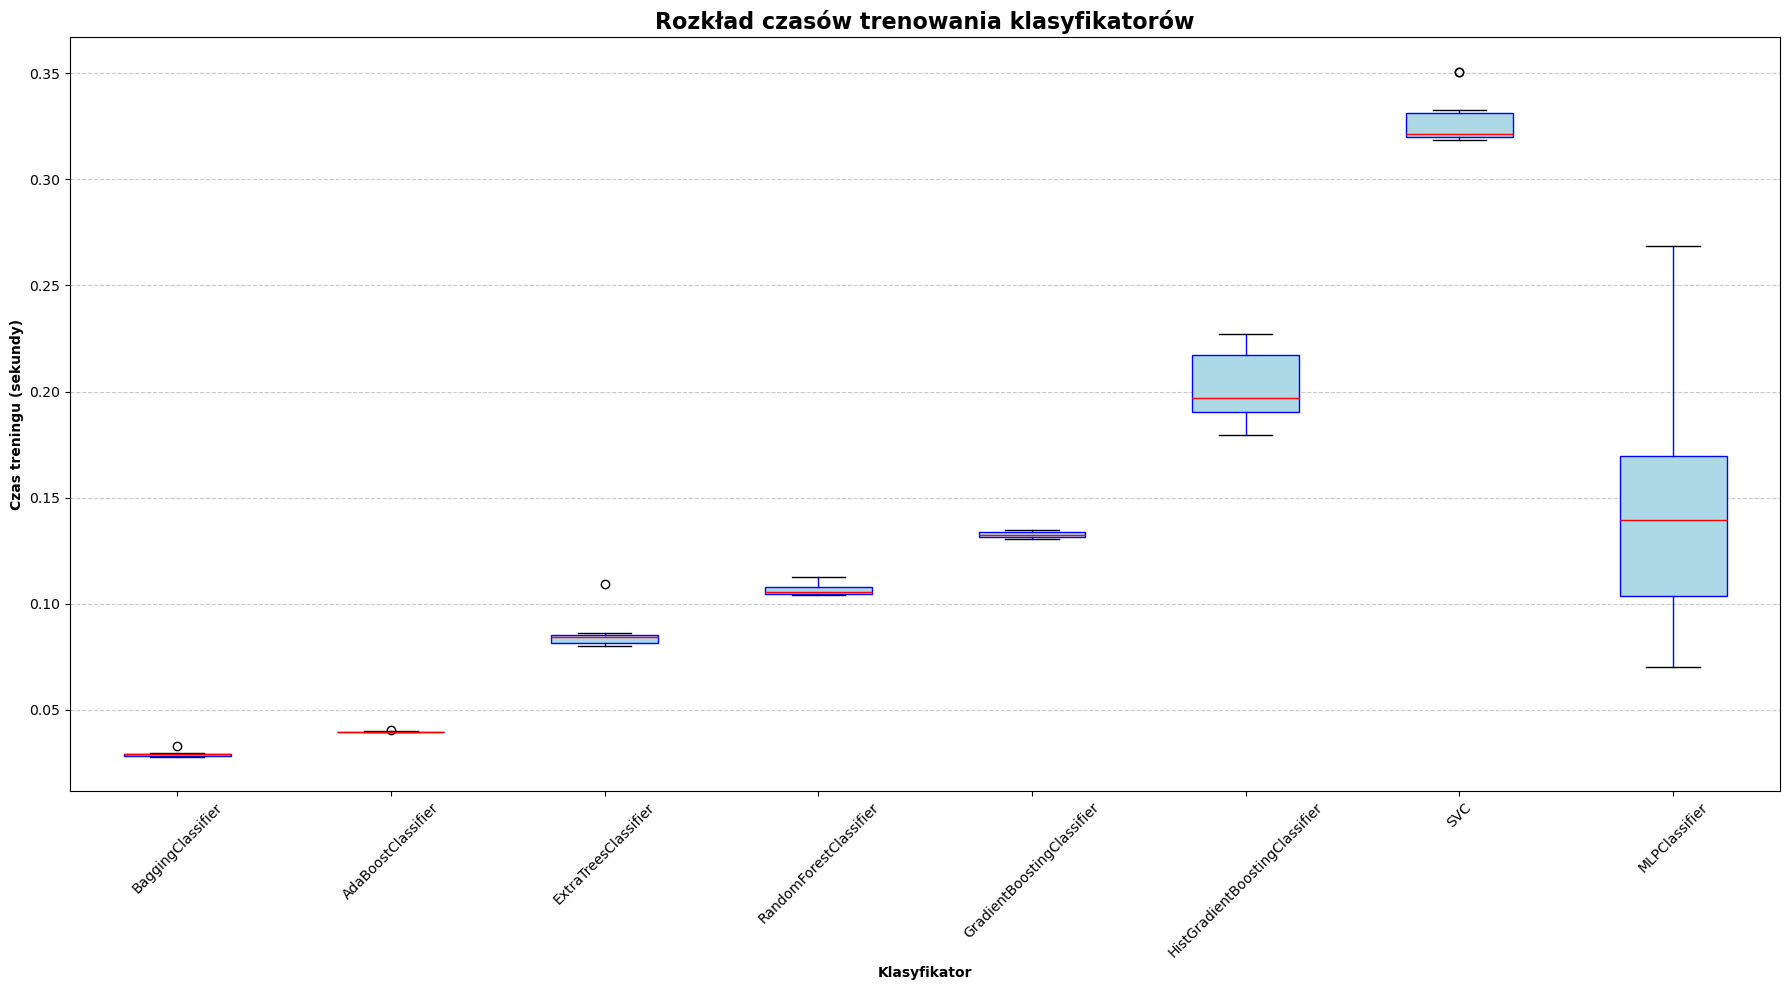

In [22]:
times()

Modele `MLPClassifier` oraz `SVC` są najbardziej kosztowne, mimo że zapewniają potencjalnie najgorsze wyniki.

Wśród pozostałych modeli, najgorzej sprawował się model `HistGradientBoostingClassifier`.

Pozostałe 5 modeli posiada dość dobre średnie czasy treningu, w zakresie około 30-150 ms.

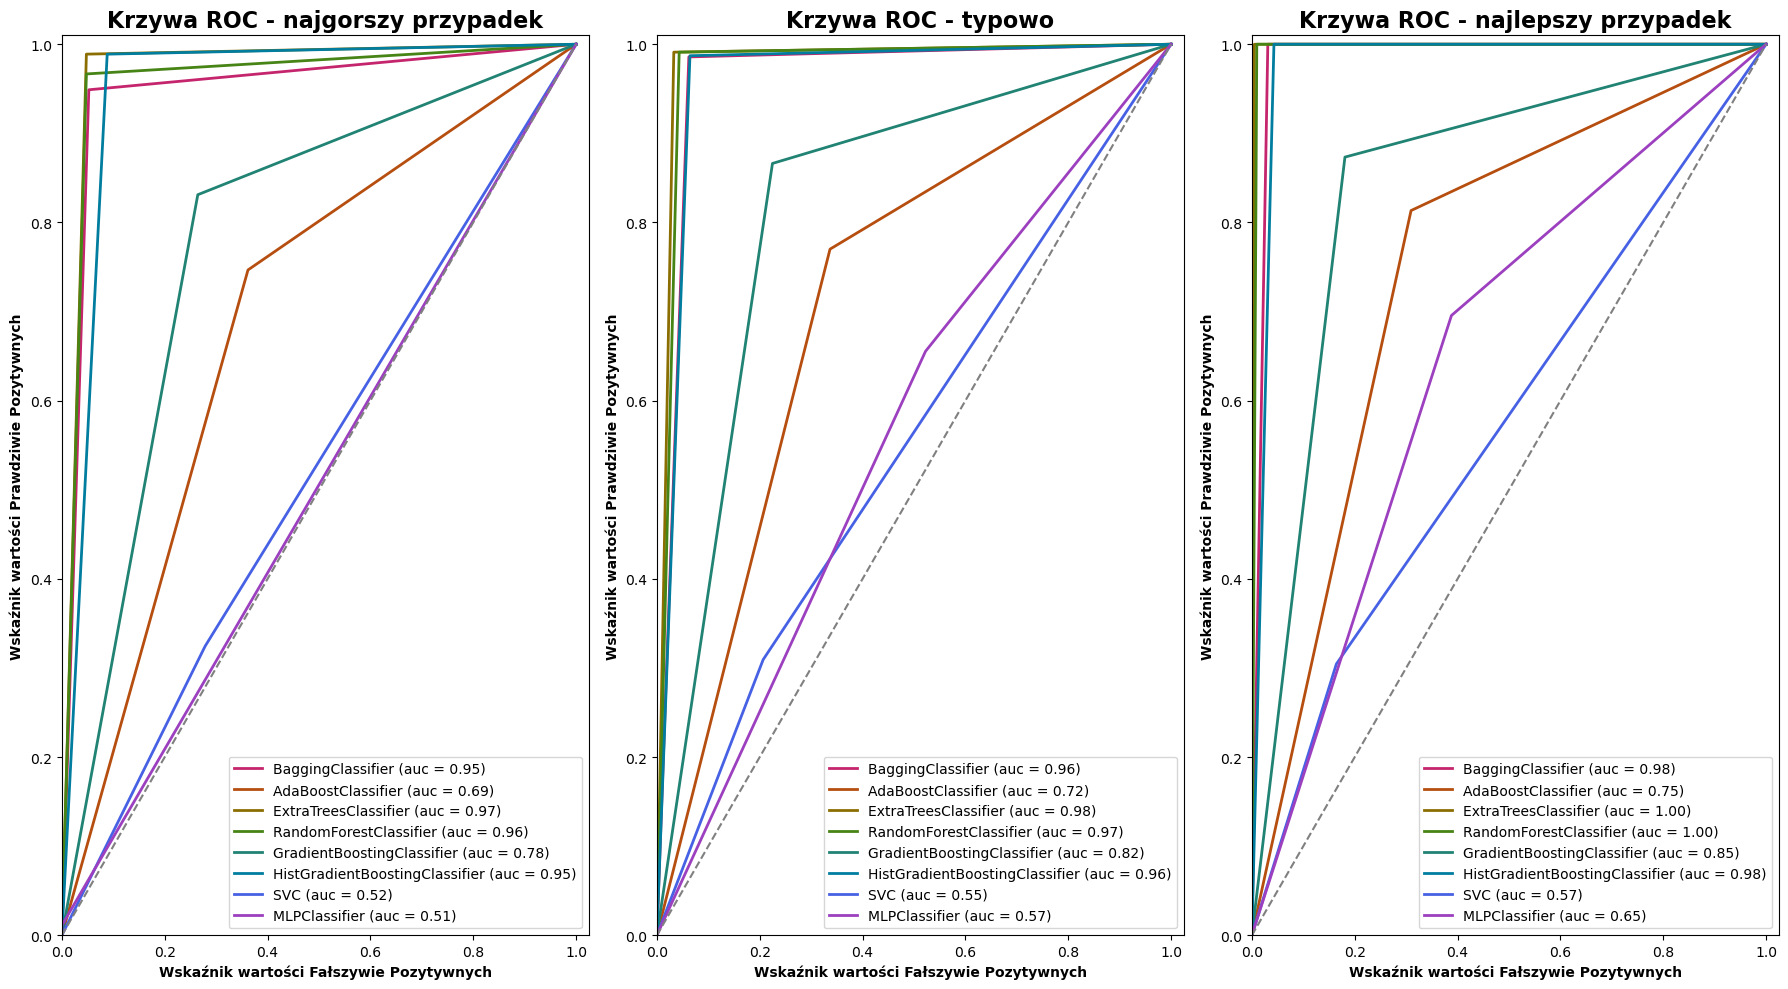

In [23]:
roc()

Przy ewaluacji krzywych ROC dużo wyraźniej widać które modele jak się sprawowały.

Po pierwsze, po raz kolejny potwierdza się prowadzenie modeli `ExtraTreesClassifier` oraz `RandomForestClassifier` - modele te jako jedyne osiągnęły idealny wynik *auc=1.0* w najlepszym z przypadków, ale również nie spadły w najgorszym przypadku poniżej wartości *0.96* - na prowadzenie wychodzi tu ten pierwszy, z wyższym wskaźnikiem prawdziwie pozytywnych trafów.

Klasyfikatory `BaggingClassifier` oraz `HistGradientClassifier` również zdają się utrzymywać bardzo dobry poziom predykcji, przy czym ten pierwszy zdaje się produkować mniej wartości fałszywie pozytywnych.

Również potwierdza się, że modele nie-liniowe wyraźnie gorzej radzą sobie z klasyfikacją - w najgorszym przypadku są one niemal całkiem losowe. Model SVC zazwyczaj posiada niższą wartość AUC, jednak `MLPClassifier` zdaje się wykazywać większy udział *False Positive*.

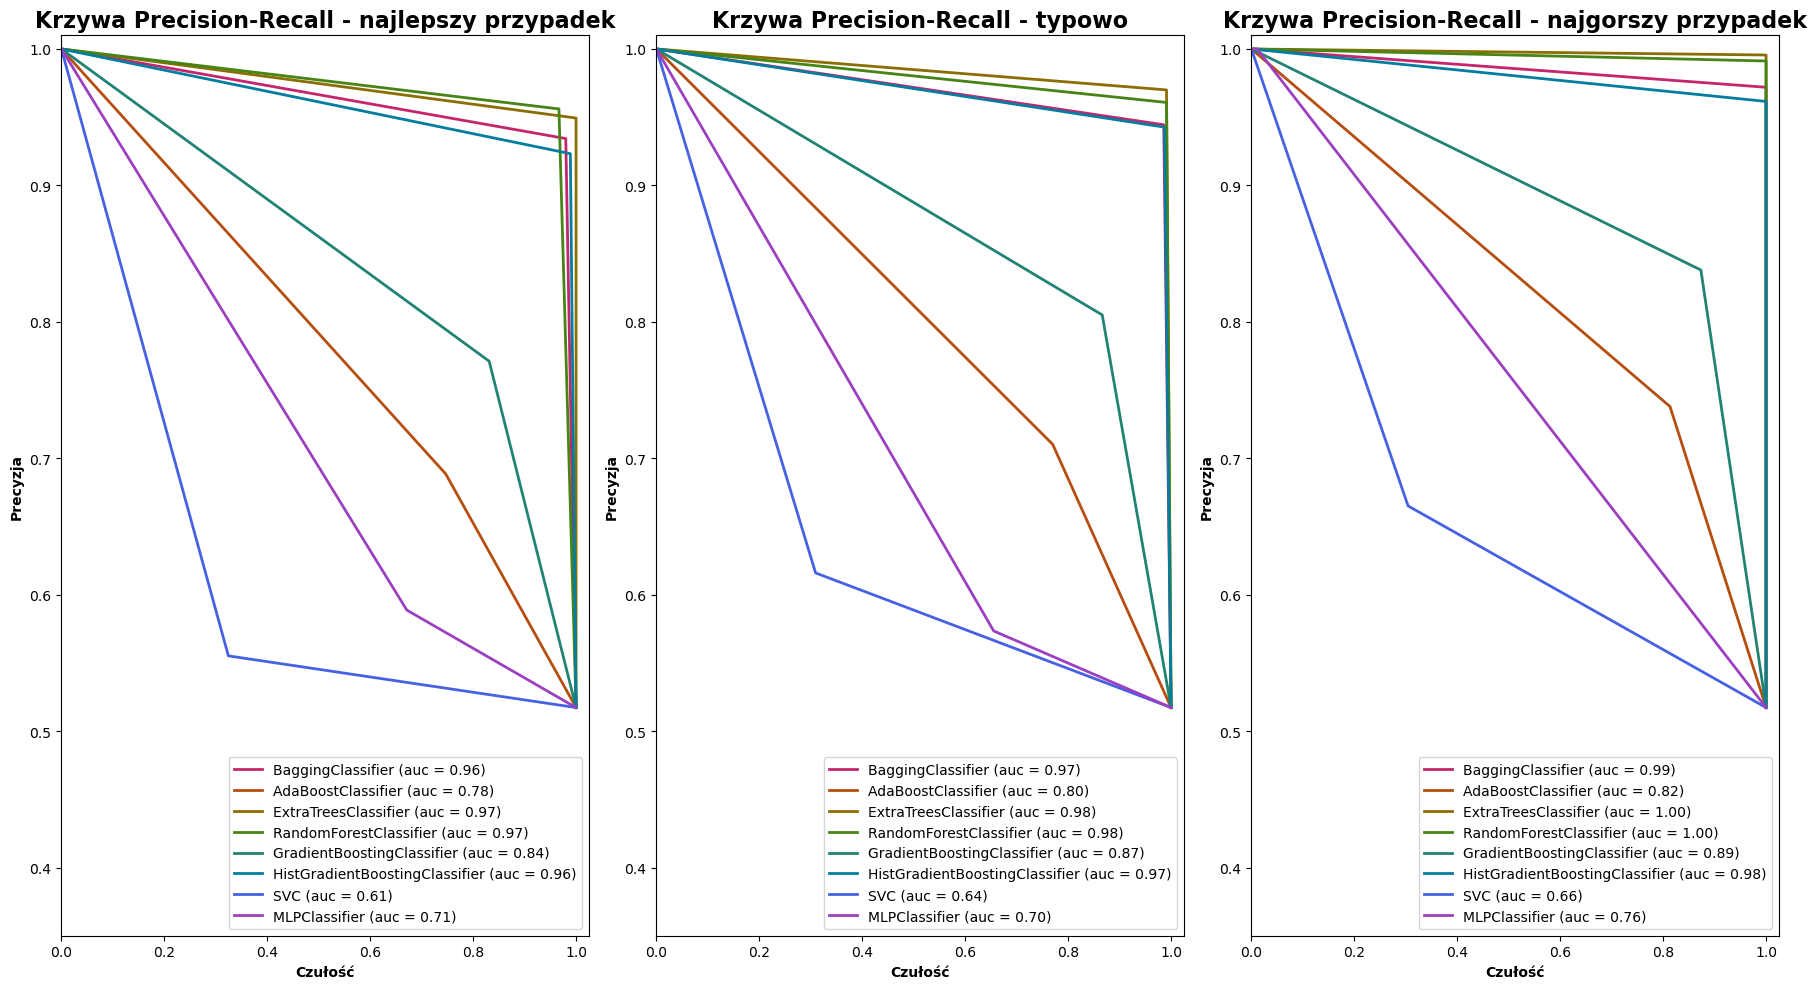

In [24]:
prc()

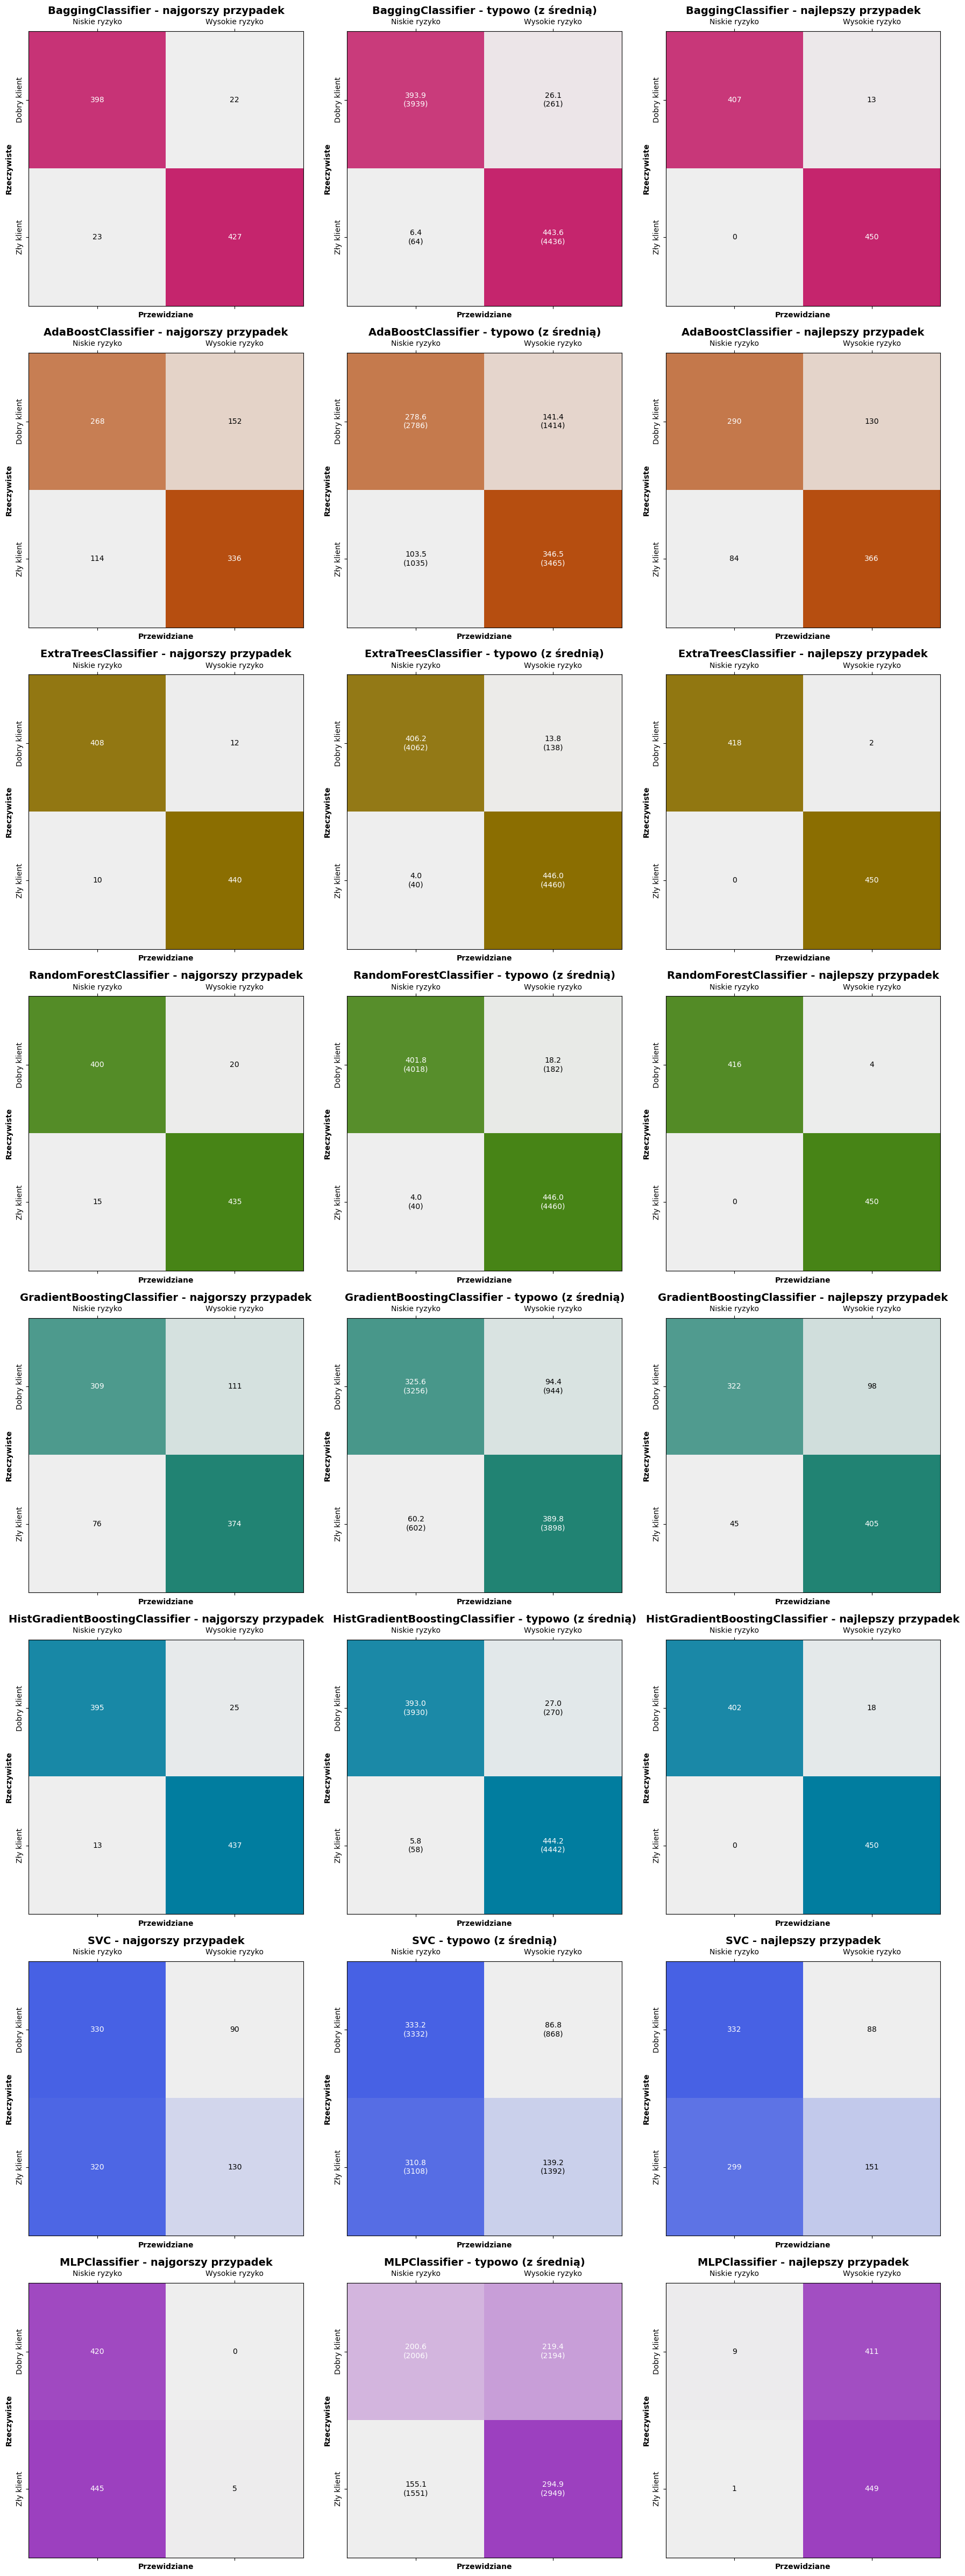

In [25]:
con_mat()

Analiza macierzy pomyłek pozwala jednoznacznie wykluczyć model `SVC` - błędnie klasyfikuje on dużą liczbę obserwacji.

Widać także że klasyfikator `MLPClassifier` zachowuje się w bardzo losowy sposób, niemalże równomiernie rozkładając wszystkie obserwacje w każdej części macierzy w typowym przypadku.

Co ważne, zauważyć można że każdy z modeli drzewiastych ma tendencję do częstszego popełniania błędów *False Negative*.

## Wnioski

Przy braku modyfikacji parametrów / pozostawieniu wartości domyślnych, modele oparte o drzewa losowe najlepiej sprawdzały się przy klasyfikacji rozważanego zestawu danych - w szczególności przy jedynie 10 losowaniach (treningach z inną wartością `random_state` / inaczej wylosowanym podziałem na dane treningowe / testowe) udało się uzyskać model `ExtraTreesClassifier` który popełnił błędy na <0.25% obserwacjach testowych. \
Istnieje szansa że przy próbie dostrajania klasyfikatorów przy kolejnych teningach, udałoby się uzyskać lepsze wyniki także dla pozostałych modeli.

Model `ExtraTreesClassifier` tym samym wygrywa, niewielką przewagą nad modelem `RandomForestClassifier` (niewielką w stosunku do rozmiarów zestawu treningowego - ale drugi model popełnił 2x więcej błędów), popełniając zaledwie 2 błędy przy 900 obserwacjach testowych. Zapewnia on również zadowalająco krótki czas treningu.

Zauważyć można, że większość modeli - tych które nie wykazywały bezużytecznej predykcji, miała tendencję do popełniania większej ilości błędów *FN* aniżeli *FP*, co oczywiście jest sytuacją bardziej pożądaną, jako że strata klienta któremu nie udzielono kredytu (*FN*) wiąże się jedynie ze stratą przychodu, natomiast udzielenie kredytu klientowi który w przyszłości będzie niewypłacalny (*FP*) oznacza potencjalnie stratę również pożyczonego kapitału. \
Powodem takiej stronniczości może być przyjęta strategia balansowania danych; jak wcześniej wspomniano po balansowaniu stosunek pozytywów do negatywów wynosił 1:1.07 (co było poprawą względem początkowego stosunku obserwacji klas) - większy udział obserwacji dla klientów z wysokim ryzykiem mógł przyczynić się do wykształcenia w modelach skłonności do klasyfikacji klientów jako złych.